In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import LSTM
from keras.models import load_model
import keras
import h5py
import requests
import os

C:\Users\Alexandre\AppData\Local\Temp\ipykernel_23736\3146065630.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
df_tweets = pd.read_csv("completeDataset_inference.csv")
df_news = pd.read_csv("completeDatasetNews.csv")

In [3]:
df_news_likes = df_news[['Date', 'Likes']]
df_news_likes['Date'] = df_news_likes['Date'].apply(lambda dt: dt[:11])

C:\Users\Alexandre\AppData\Local\Temp\ipykernel_23736\149700250.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_news_likes['Date'] = df_news_likes['Date'].apply(lambda dt: dt[:11])


In [4]:
df_news_likes

,Date,Likes
0,2022-01-01,163
1,2022-01-01,178
2,2022-01-01,458
3,2022-01-02,8
4,2022-01-02,13
...,...,...
24267,2023-04-29,435
24268,2023-04-29,456
24269,2023-04-29,82
24270,2023-04-29,109


In [5]:
max_news = df_news_likes[['Date', 'Likes']].groupby(['Date'])['Likes'].max()
max_news = pd.DataFrame({'date':max_news.index, 'max':max_news.values})

In [6]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import plotly.express as px

fig2 = px.scatter(max_news, x="date", y="max", color='max')
fig2.show()

In [7]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
dataset = min_max_scaler.fit_transform(max_news['max'].values.reshape(-1, 1))

In [8]:
lb = 99

In [9]:
dataset[0:10]


array([[0.00727102],
       [0.0099391 ],
       [0.00317725],
       [0.00368643],
       [0.00085541],
       [0.01582517],
       [0.00238294],
       [0.00077395],
       [0.00034624],
       [0.00103872]])

In [10]:
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

338 146


In [11]:
def create_dataset(dataset, look_back=lb):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [12]:
x_train, y_train = create_dataset(train, look_back=lb)
x_test, y_test = create_dataset(test, look_back=lb)

In [13]:
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

In [14]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(238, 1, 99)
(238,)
(46, 1, 99)
(46,)


In [15]:
look_back = lb
model = Sequential()
model.add(LSTM(20, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
238/238 - 5s - loss: 0.0032 - 5s/epoch - 22ms/step
Epoch 2/100
238/238 - 1s - loss: 0.0025 - 603ms/epoch - 3ms/step
Epoch 3/100
238/238 - 1s - loss: 0.0023 - 613ms/epoch - 3ms/step
Epoch 4/100
238/238 - 1s - loss: 0.0021 - 650ms/epoch - 3ms/step
Epoch 5/100
238/238 - 1s - loss: 0.0020 - 596ms/epoch - 3ms/step
Epoch 6/100
238/238 - 1s - loss: 0.0019 - 608ms/epoch - 3ms/step
Epoch 7/100
238/238 - 1s - loss: 0.0018 - 571ms/epoch - 2ms/step
Epoch 8/100
238/238 - 1s - loss: 0.0018 - 583ms/epoch - 2ms/step
Epoch 9/100
238/238 - 1s - loss: 0.0017 - 590ms/epoch - 2ms/step
Epoch 10/100
238/238 - 1s - loss: 0.0016 - 611ms/epoch - 3ms/step
Epoch 11/100
238/238 - 1s - loss: 0.0017 - 636ms/epoch - 3ms/step
Epoch 12/100
238/238 - 1s - loss: 0.0016 - 691ms/epoch - 3ms/step
Epoch 13/100
238/238 - 1s - loss: 0.0015 - 583ms/epoch - 2ms/step
Epoch 14/100
238/238 - 1s - loss: 0.0014 - 587ms/epoch - 2ms/step
Epoch 15/100
238/238 - 1s - loss: 0.0014 - 635ms/epoch - 3ms/step
Epoch 16/100
238/238 

In [16]:
trainPredict = model.predict(x_train)
testPredict = model.predict(x_test)
# invert predictions
trainPredict = min_max_scaler.inverse_transform(trainPredict)
trainY = min_max_scaler.inverse_transform([y_train])
testPredict = min_max_scaler.inverse_transform(testPredict)
testY = min_max_scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 323.26 RMSE
Test Score: 3589.96 RMSE


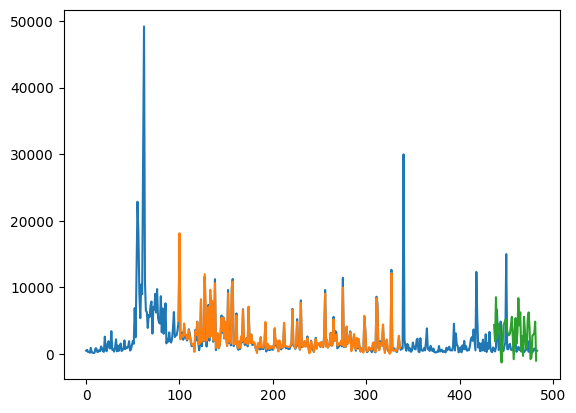

In [17]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(min_max_scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [18]:
df_news_likes_2 = df_news[['Date', 'Likes']]
df_news_likes_2['Date'] = df_news_likes_2['Date'].apply(lambda dt: dt[:11])

C:\Users\Alexandre\AppData\Local\Temp\ipykernel_23736\1278876005.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [19]:
max_news2 = df_news_likes_2[['Date', 'Likes']].groupby(['Date'])['Likes'].max()
max_news2 = pd.DataFrame({'date':max_news2.index, 'max':max_news2.values})

In [20]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import plotly.express as px

fig2 = px.scatter(max_news2, x="date", y="max", color='max')
fig2.show()

In [21]:
dataset = min_max_scaler.fit_transform(max_news2['max'].values.reshape(-1, 1))

In [22]:
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

338 146


In [23]:
lb = 10

In [24]:
x_train, y_train = create_dataset(train, look_back=lb)
x_test, y_test = create_dataset(test, look_back=lb)

In [25]:
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

In [26]:
look_back = lb
model = Sequential()
model.add(LSTM(20, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
327/327 - 2s - loss: 0.0069 - 2s/epoch - 5ms/step
Epoch 2/100
327/327 - 1s - loss: 0.0064 - 801ms/epoch - 2ms/step
Epoch 3/100
327/327 - 1s - loss: 0.0060 - 953ms/epoch - 3ms/step
Epoch 4/100
327/327 - 1s - loss: 0.0058 - 905ms/epoch - 3ms/step
Epoch 5/100
327/327 - 1s - loss: 0.0058 - 844ms/epoch - 3ms/step
Epoch 6/100
327/327 - 1s - loss: 0.0057 - 888ms/epoch - 3ms/step
Epoch 7/100
327/327 - 1s - loss: 0.0055 - 990ms/epoch - 3ms/step
Epoch 8/100
327/327 - 1s - loss: 0.0054 - 922ms/epoch - 3ms/step
Epoch 9/100
327/327 - 1s - loss: 0.0055 - 791ms/epoch - 2ms/step
Epoch 10/100
327/327 - 1s - loss: 0.0055 - 851ms/epoch - 3ms/step
Epoch 11/100
327/327 - 1s - loss: 0.0054 - 854ms/epoch - 3ms/step
Epoch 12/100
327/327 - 1s - loss: 0.0053 - 777ms/epoch - 2ms/step
Epoch 13/100
327/327 - 1s - loss: 0.0053 - 790ms/epoch - 2ms/step
Epoch 14/100
327/327 - 1s - loss: 0.0053 - 801ms/epoch - 2ms/step
Epoch 15/100
327/327 - 1s - loss: 0.0052 - 843ms/epoch - 3ms/step
Epoch 16/100
327/327 -

In [27]:
trainPredict = model.predict(x_train)
testPredict = model.predict(x_test)
# invert predictions
trainPredict = min_max_scaler.inverse_transform(trainPredict)
trainY = min_max_scaler.inverse_transform([y_train])
testPredict = min_max_scaler.inverse_transform(testPredict)
testY = min_max_scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2858.70 RMSE
Test Score: 2294.55 RMSE


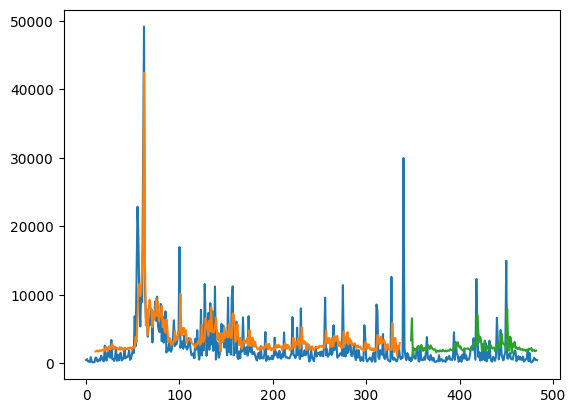

In [28]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(min_max_scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [29]:
cnt_news = df_news_likes[['Date']].groupby(['Date'])['Date'].count()
cnt_news = pd.DataFrame({'date':cnt_news.index, 'cnt':cnt_news.values})


In [30]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import plotly.express as px

fig2 = px.scatter(cnt_news, x="date", y="cnt", color='cnt')
fig2.show()

In [31]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
dataset = min_max_scaler.fit_transform(cnt_news['cnt'].values.reshape(-1, 1))

train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

lb = 5

x_train, y_train = create_dataset(train, look_back=lb)
x_test, y_test = create_dataset(test, look_back=lb)

x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

look_back = lb
model = Sequential()
model.add(LSTM(20, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
332/332 - 2s - loss: 0.0131 - 2s/epoch - 5ms/step
Epoch 2/100
332/332 - 1s - loss: 0.0063 - 834ms/epoch - 3ms/step
Epoch 3/100
332/332 - 1s - loss: 0.0054 - 855ms/epoch - 3ms/step
Epoch 4/100
332/332 - 1s - loss: 0.0051 - 806ms/epoch - 2ms/step
Epoch 5/100
332/332 - 1s - loss: 0.0053 - 811ms/epoch - 2ms/step
Epoch 6/100
332/332 - 1s - loss: 0.0049 - 800ms/epoch - 2ms/step
Epoch 7/100
332/332 - 1s - loss: 0.0047 - 787ms/epoch - 2ms/step
Epoch 8/100
332/332 - 1s - loss: 0.0047 - 787ms/epoch - 2ms/step
Epoch 9/100
332/332 - 1s - loss: 0.0047 - 825ms/epoch - 2ms/step
Epoch 10/100
332/332 - 1s - loss: 0.0045 - 790ms/epoch - 2ms/step
Epoch 11/100
332/332 - 1s - loss: 0.0044 - 807ms/epoch - 2ms/step
Epoch 12/100
332/332 - 1s - loss: 0.0046 - 790ms/epoch - 2ms/step
Epoch 13/100
332/332 - 1s - loss: 0.0046 - 798ms/epoch - 2ms/step
Epoch 14/100
332/332 - 1s - loss: 0.0046 - 804ms/epoch - 2ms/step
Epoch 15/100
332/332 - 1s - loss: 0.0042 - 821ms/epoch - 2ms/step
Epoch 16/100
332/332 -

In [32]:
trainPredict = model.predict(x_train)
testPredict = model.predict(x_test)
# invert predictions
trainPredict = min_max_scaler.inverse_transform(trainPredict)
trainY = min_max_scaler.inverse_transform([y_train])
testPredict = min_max_scaler.inverse_transform(testPredict)
testY = min_max_scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 24.01 RMSE
Test Score: 14.24 RMSE


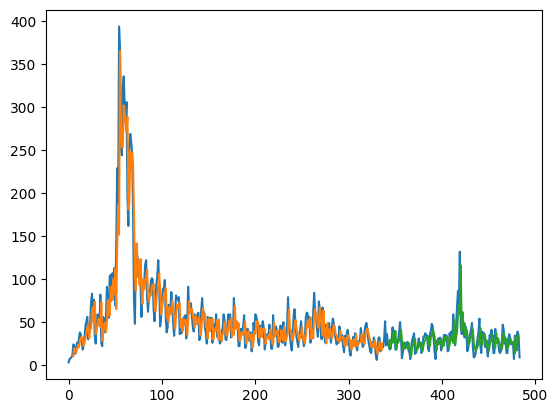

In [33]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(min_max_scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()